#VGG16Places: Caffe to Lasagne transcoding

In [10]:
import caffe
import cv2
import pandas as pd

import lasagne
from lasagne.layers import InputLayer, DropoutLayer, FlattenLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.utils import floatX
from lasagne.nonlinearities import softmax
import theano.tensor as T
import theano
from collections import OrderedDict

import numpy as np

import cPickle as pickle

import matplotlib.pyplot as plt
%matplotlib inline  

Download the VGG16 Caffe model for Places from: http://places.csail.mit.edu/model/places205vgg.tar.gz <br>
Extract it on the root directory of your project

In [11]:
net_caffe = caffe.Net('places205VGG16/deploy_10.prototxt', 'places205VGG16/snapshot_iter_765280.caffemodel', caffe.TEST)
categories = pd.read_csv('places205VGG16/categoryIndex_places205.csv',header=None,names=['place'])

Create an empty VGG16 Lasagne model 

In [4]:
inputImage = T.tensor4()

net = OrderedDict()
net['input'] = InputLayer((None, 3, 224, 224), input_var=inputImage)
net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
net['pool1'] = PoolLayer(net['conv1_2'], 2)
net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
net['pool2'] = PoolLayer(net['conv2_2'], 2)
net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
net['pool3'] = PoolLayer(net['conv3_3'], 2)
net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
net['pool4'] = PoolLayer(net['conv4_3'], 2)
net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
net['pool5'] = PoolLayer(net['conv5_3'], 2)
net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=205, nonlinearity=None)
net['prob'] = NonlinearityLayer(net['fc8'], softmax)

Copy weights from the Caffe model into a the Lasange

In [5]:
layers_caffe = dict(zip(list(net_caffe._layer_names), net_caffe.layers))

for name, layer in net.items():
    try:
        if name.startswith('conv'):
            layer.W.set_value(layers_caffe[name].blobs[0].data)
            layer.b.set_value(layers_caffe[name].blobs[1].data)   
        else:
            layer.W.set_value(layers_caffe[name].blobs[0].data.T) # Transposed!!
            layer.b.set_value(layers_caffe[name].blobs[1].data)   
    except AttributeError:
        continue

Let's take a test image. Whichever you like but containing a "place" :)

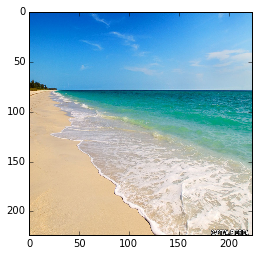

In [7]:
#Adjust color space and size to parse with the VGG
beach = cv2.resize( cv2.cvtColor( cv2.imread('/tmp/beach.jpg'), cv2.COLOR_BGR2RGB ), (224,224) )
plt.imshow(beach)

Out of the README.txt together with the Caffe model, there are the mean values for each channel

In [8]:
meanImg = np.array([[[ 105.487823486]], [[ 113.741088867]], [[ 116.060394287]]])

Process the input image through Caffe

In [23]:
caffe.set_mode_gpu()
net_caffe.blobs['data'].data[...] = (beach.astype(theano.config.floatX).transpose(2,0,1) - meanImg)
outputCaffe = net_caffe.forward()

Classification results for Caffe

In [24]:
outputCaffeSorted = sorted(zip(list(outputCaffe['prob'][0]),range(255)), key=lambda x:x[0], reverse=True)

for k in outputCaffeSorted[:10]:
    print categories.ix[k[1]]['place']

/o/ocean 128
/c/coast 47
/s/sandbar 161
/s/sky 170
/r/river 156
/i/islet 102
/s/sea_cliff 163
/s/snowfield 173
/i/iceberg 100
/c/crevasse 59


Now, let's try to reproduce the same results with the transcoded model into Lasange.<br>
First, compile the functions in Lasagne

In [21]:
test_prediction = lasagne.layers.get_output(net['prob'], deterministic=True)
predictFunction = theano.function([inputImage], test_prediction)

In [25]:
dat = np.zeros((1,3,224,224)).astype(theano.config.floatX)
dat[0,...] = (beach.astype(theano.config.floatX).transpose(2,0,1) - meanImg)
outputLasagne = predictFunction(dat)

In [27]:
outputLasagneSorted = sorted(zip(list(outputLasagne[0]),range(255)), key=lambda x:x[0], reverse=True)

for k in outputLasagneSorted[:10]:
    print categories.ix[k[1]]['place']

/o/ocean 128
/c/coast 47
/s/sandbar 161
/s/sky 170
/r/river 156
/i/islet 102
/s/sea_cliff 163
/s/snowfield 173
/i/iceberg 100
/c/crevasse 59


<b>At this point, we conclude that the VGG16 Places transcoding from Caffe to Lasagne does produce the same results.</b>

For our experiments, we only need the convolutional part of the VGG16 model. We will be saving up to the 'pool5' layer in a pickle file.

In [28]:
modelToSave = {}

modelToSave['params'] = lasagne.layers.get_all_param_values(net['pool5'])
modelToSave['meanImg'] = meanImg
modelToSave['scaleFactor'] = 1.0

with open('ConvVGG_Places.pkl', 'wb') as f:
    pickle.dump( modelToSave, f )